Objective: Take a sentence as input and output a sentiment

Data : [UMICH SI650 sentiment classification competition on Kaggle](https://inclass.kaggle.com/c/si650winter11) 

### 1. Package Management

In [3]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os

### 2.  Exploratory Analysis


In [27]:
DATA_DIR = "./data"
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0


#ftrain = open(os.path.join(DATA_DIR, "umich.txt"), 'rb')

with open (os.path.join(DATA_DIR, "umich.txt"), 'rb') as f:
    lines=[ x.decode('utf8').strip() for x in f.readlines()]

    for line in lines:
        label, sentence = line.strip().split("\t")
        words = nltk.word_tokenize(sentence.lower())
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            word_freqs[word] += 1
        num_recs += 1
#ftrain.close()

In [33]:
print("Max no of words in a sentence : %s" %(maxlen))
print("Unique Words in trainig data : %s" % (len(word_freqs)))

Max no of words in a sentence : 42
Unique Words in trainig data : 2328


### 3. Hyperparameters


Max_Features means the vocab size of unique words. We set it to 2000 so as to eliminate the least frequently occuring 300 words.


We also set the seq size to be fed to the RNN to 40. Shorter sentences will be padded and longer sentences will be truncated.

In [39]:
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40




### 4. Create lookup tables 

Each row of input to the RNN is a sequence of word indices, where the indices are ordered by most frequent to least frequent word in the training set.

The two lookup tables allow us to lookup an index given the word and the word given the index. This includes the PAD and UNK pseudo-words as well:

In [118]:
vocab_size=min(MAX_FEATURES,len(word_freqs))+2
vocab_size

2002

In [66]:
# Word to Index table. Get only top 2000 most used words and create a dict

word2index={x[0]:i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}

# Add special keywords

word2index["PAD"]=0
word2index["UNK"]=1

word2index


{'i': 2,
 ',': 3,
 '.': 4,
 'the': 5,
 'and': 6,
 '!': 7,
 'harry': 8,
 'vinci': 9,
 'da': 10,
 'brokeback': 11,
 'code': 12,
 'mountain': 13,
 'potter': 14,
 '...': 15,
 'love': 16,
 'is': 17,
 'a': 18,
 'was': 19,
 'mission': 20,
 'impossible': 21,
 'awesome': 22,
 'like': 23,
 'it': 24,
 'to': 25,
 'movie': 26,
 'that': 27,
 "'s": 28,
 'because': 29,
 'sucks': 30,
 'hate': 31,
 'sucked': 32,
 'so': 33,
 'as': 34,
 'my': 35,
 '``': 36,
 'much': 37,
 'of': 38,
 'really': 39,
 'movies': 40,
 'stupid': 41,
 'you': 42,
 'down': 43,
 'but': 44,
 'we': 45,
 'be': 46,
 'with': 47,
 'just': 48,
 'one': 49,
 'know': 50,
 'potter..': 51,
 'suck': 52,
 'out': 53,
 '3': 54,
 'who': 55,
 '/': 56,
 'or': 57,
 'am': 58,
 'loved': 59,
 'want': 60,
 'into': 61,
 'which': 62,
 'right': 63,
 'for': 64,
 'an': 65,
 "n't": 66,
 'this': 67,
 'me': 68,
 ':': 69,
 'are': 70,
 'think': 71,
 'not': 72,
 'how': 73,
 'if': 74,
 'depressing': 75,
 'people': 76,
 'his': 77,
 'would': 78,
 'up': 79,
 'reading': 80

In [72]:
# Create index to word dict

index2word={v:k for k,v in word2index.items()}
index2word

{2: 'i',
 3: ',',
 4: '.',
 5: 'the',
 6: 'and',
 7: '!',
 8: 'harry',
 9: 'vinci',
 10: 'da',
 11: 'brokeback',
 12: 'code',
 13: 'mountain',
 14: 'potter',
 15: '...',
 16: 'love',
 17: 'is',
 18: 'a',
 19: 'was',
 20: 'mission',
 21: 'impossible',
 22: 'awesome',
 23: 'like',
 24: 'it',
 25: 'to',
 26: 'movie',
 27: 'that',
 28: "'s",
 29: 'because',
 30: 'sucks',
 31: 'hate',
 32: 'sucked',
 33: 'so',
 34: 'as',
 35: 'my',
 36: '``',
 37: 'much',
 38: 'of',
 39: 'really',
 40: 'movies',
 41: 'stupid',
 42: 'you',
 43: 'down',
 44: 'but',
 45: 'we',
 46: 'be',
 47: 'with',
 48: 'just',
 49: 'one',
 50: 'know',
 51: 'potter..',
 52: 'suck',
 53: 'out',
 54: '3',
 55: 'who',
 56: '/',
 57: 'or',
 58: 'am',
 59: 'loved',
 60: 'want',
 61: 'into',
 62: 'which',
 63: 'right',
 64: 'for',
 65: 'an',
 66: "n't",
 67: 'this',
 68: 'me',
 69: ':',
 70: 'are',
 71: 'think',
 72: 'not',
 73: 'how',
 74: 'if',
 75: 'depressing',
 76: 'people',
 77: 'his',
 78: 'would',
 79: 'up',
 80: 'reading'

### 5. Convert Sentences to Word Index sequences

- Pad the sentences when they fall short of Sequence length
- Trim the sentences when they exceed the length
- Define inputs and outputs as word index seq
- OUtputs would be a binay sentiment (positive or negative)


In [104]:
# Intialize input and ouput

x=np.empty((num_recs,),dtype=list)
y=np.empty((num_recs))

In [105]:
i = 0



with open (os.path.join(DATA_DIR, "umich.txt"), 'rb') as f:
    lines=[ x.decode('utf8').strip() for x in f.readlines()]
lines[1]

"1\tthis was the first clive cussler i've ever read, but even books like Relic, and Da Vinci code were more plausible than this."

In [106]:
# Note the \t in previous output. We will use that as a separator to create our label(sentiment - 0 or 1) and sentnce.

for i,line in enumerate(lines):
    label,sentence=line.strip().split("\t")
    words=nltk.word_tokenize(sentence.lower())
    
    # Convert current sentence to word index seq
    seq=[]
    
    for word in words:
        if word in word2index:
            seq.append(word2index[word])
        else:
            seq.append(word2index["UNK"])
    x[i]=seq
    y[i]=int(label)
    
    
    
    

    

In [108]:
# Pad the input sequences .. this is a keras function
x=sequence.pad_sequences(x,MAX_SENTENCE_LENGTH)

In [111]:
# Split into test and training set

xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2, random_state=42)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(5668, 40) (1418, 40) (5668,) (1418,)


In [114]:
# Lets look at the inputs and outputs at this time

xtrain

array([[   0,    0,    0, ...,    7,    7,    7],
       [   0,    0,    0, ...,   30,   94,  275],
       [   0,    0,    0, ...,  116, 1979,    4],
       ..., 
       [   0,    0,    0, ...,   40,    7,   92],
       [   0,    0,    0, ...,  208,   47,    4],
       [   0,    0,    0, ...,   18,  140,    4]])

In [115]:
ytrain

array([ 1.,  0.,  0., ...,  0.,  0.,  1.])

### 6. Build the Model 

In [116]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

Network Structure

Embedding Layer --> LSTM Layer --> Dense Layer (Binary Cross Entropy Loss with Adam Optimizer)

In [124]:
model=Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_SENTENCE_LENGTH))

# Giving error 'not supported between instances of 'Dropout' and 'float'
#model.add(SpatialDropout1D(Dropout(0.2)))

model.add(LSTM(HIDDEN_LAYER_SIZE,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))


model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])




### 7. Train the network

In [125]:
history=model.fit(xtrain,ytrain,batch_size=BATCH_SIZE,epochs=NUM_EPOCHS,validation_data=(xtest,ytest))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 13s - loss: 0.2176 - acc: 0.9091 - val_loss: 0.0531 - val_acc: 0.9795
Epoch 2/10
5668/5668 [==============================] - 12s - loss: 0.0275 - acc: 0.9915 - val_loss: 0.0492 - val_acc: 0.9838
Epoch 3/10
5668/5668 [==============================] - 13s - loss: 0.0091 - acc: 0.9975 - val_loss: 0.0412 - val_acc: 0.9880
Epoch 4/10
5668/5668 [==============================] - 13s - loss: 0.0047 - acc: 0.9995 - val_loss: 0.0556 - val_acc: 0.9845
Epoch 5/10
5668/5668 [==============================] - 12s - loss: 0.0029 - acc: 0.9995 - val_loss: 0.0539 - val_acc: 0.9880
Epoch 6/10
5668/5668 [==============================] - 12s - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0782 - val_acc: 0.9803
Epoch 7/10
5668/5668 [==============================] - 13s - loss: 0.0029 - acc: 0.9991 - val_loss: 0.0675 - val_acc: 0.9838
Epoch 8/10
5668/5668 [==============================] - 12s - loss: 0.

### 8. Plot Loss and Accuracy 

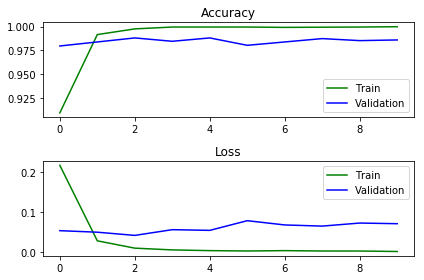

In [126]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### 9. Evaluation 

In [127]:
score, acc= model.evaluate(xtest,ytest,batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

1376/1418 [============================>.] - ETA: 0sTest score: 0.071, accuracy: 0.986


In [131]:
for i in range(5):
    idx = np.random.randint(len(xtest))
    x_test = xtest[idx].reshape(1,40)
    ylabel = ytest[idx]
    ypred = model.predict(x_test)[0][0]
    sent = " ".join([index2word[x] for x in x_test[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (ypred, ylabel, sent))

1	1	the people who are worth it know how much i love the da vinci code .
1	1	the people who are worth it know how much i love the da vinci code .
1	1	the people who are worth it know how much i love the da vinci code .
1	1	the people who are worth it know how much i love the da vinci code .
1	1	the people who are worth it know how much i love the da vinci code .
